# MODELO RELACIONAL

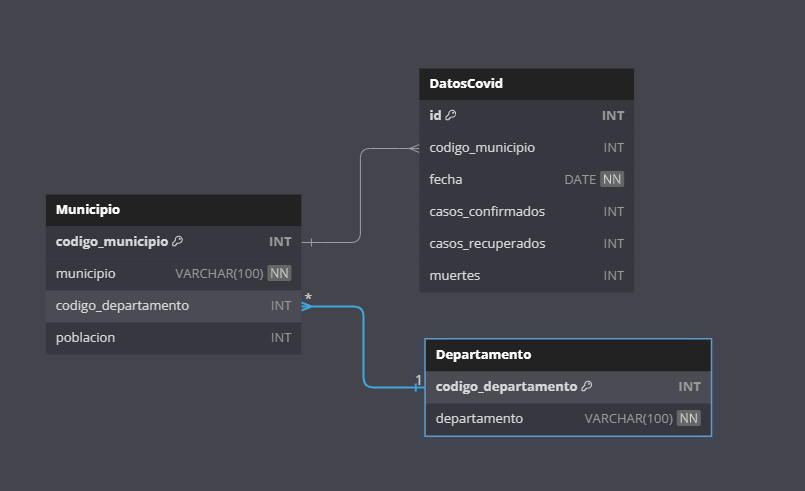

# SCRIPT SQL

```sql
CREATE TABLE Departamento (
  codigo_departamento INT PRIMARY KEY,
  departamento VARCHAR(100) NOT NULL
);

CREATE TABLE Municipio (
  codigo_municipio INT PRIMARY KEY,
  municipio VARCHAR(100) NOT NULL,
  codigo_departamento INT,
  poblacion INT,
  FOREIGN KEY (codigo_departamento) REFERENCES Departamento(codigo_departamento)
);

CREATE TABLE DatosCovid (
  id INT PRIMARY KEY,
  codigo_municipio INT,
  fecha DATE NOT NULL,
  casos_confirmados INT,
  casos_recuperados INT,
  muertes INT,
  FOREIGN KEY (codigo_municipio) REFERENCES Municipio(codigo_municipio)
);

```

# Importación de Librerías

In [31]:
import sqlite3  # Para conectar y realizar consultas en una base de datos SQLite.
import matplotlib.pyplot as plt  # Para crear visualizaciones (gráficos).
import pandas as pd  # Para trabajar con conjuntos de datos (estructuras tabulares).
import seaborn as sns  # Complemento para gráficos con estética mejorada.
import numpy as np  # Para cálculos matemáticos y manejo de arrays.
from pygments.lexers import q
from prettytable import PrettyTable  # Para mostrar tablas formateadas en consola.
from scipy.stats import chi2_contingency  # Para realizar pruebas chi-cuadrado en datos categóricos.
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Para calcular el VIF.
from statsmodels.tools.tools import add_constant  # Para agregar un término constante (necesario para calcular el VIF).
from statsmodels.tools.tools import add_constant

# Conexión a la Base de Datos SQLite y Consulta SQL

In [32]:
# --- Conexión a la Base de Datos SQLite y Consulta SQL ---
connection = sqlite3.connect('practica1.db')  # Conectar con la base de datos SQLite.
cursor = connection.cursor()  # Crear un cursor para ejecutar comandos SQL.


In [33]:
# Consulta SQL para obtener datos de varias tablas combinadas mediante JOINs
query = """
SELECT Departamento.departamento,
       Municipio.municipio,
       Municipio.poblacion,
       DatosCovid.fecha,
       DatosCovid.muertes AS nuevas_muertes,
       DatosCovid.muertes_acumulativas AS muertes_acumuladas,
       DatosCovid.casos_confirmados AS casos_acumulados
FROM Departamento
LEFT JOIN Municipio
    ON Departamento.codigo_departamento = Municipio.codigo_departamento
LEFT JOIN DatosCovid
    ON Municipio.codigo_municipio = DatosCovid.codigo_municipio;
"""

df = pd.read_sql_query(query, connection)  # Ejecutar la consulta y cargarla en un DataFrame de Pandas.

# Mostrar información básica de los datos para verificar la carga correcta.
print("Datos consultados:")
print(df.shape)  # Dimensiones del DataFrame.
print(df.head())  # Las primeras 5 filas de los datos.

Datos consultados:
(60480, 7)
  departamento  municipio  poblacion                fecha nuevas_muertes  \
0    GUATEMALA  GUATEMALA    1205668  2020-03-15 00:00:00              0   
1    GUATEMALA  GUATEMALA    1205668  2020-03-21 00:00:00              0   
2    GUATEMALA  GUATEMALA    1205668  2020-04-15 00:00:00              0   
3    GUATEMALA  GUATEMALA    1205668  2020-04-16 00:00:00              0   
4    GUATEMALA  GUATEMALA    1205668  2020-04-17 00:00:00              0   

   muertes_acumuladas  casos_acumulados  
0                   0                 0  
1                   1                 0  
2                   5                 0  
3                   5                 0  
4                   5                 0  


# EDA MONOVARIABLE

## DATOS CUANTITATIVOS

In [34]:
# --- Función para Calcular Estadísticas Básicas ---
def mostrar_estadisticas_prettytable(df, columna):
    """
    Esta función calcula estadísticas descriptivas para una columna numérica del DataFrame
    y las muestra de forma tabular usando PrettyTable.
    """
    df[columna] = pd.to_numeric(df[columna], errors='coerce')  # Convertir la columna a valores numéricos.
    stats = df[columna].describe(percentiles=[0.25, 0.5, 0.75])  # Calcular estadísticas descriptivas.

    # Crear una tabla con los resultados:
    tabla = PrettyTable()
    tabla.field_names = ["Estadística", "Valor"]
    tabla.align = "l"

    # Agregar estadísticas a la tabla:
    tabla.add_row(["Conteo", df[columna].count()])
    tabla.add_row(["Valores únicos", df[columna].nunique()])
    tabla.add_row(["Promedio", f"{df[columna].mean():.2f}"])
    tabla.add_row(["Desviación estándar", f"{df[columna].std():.2f}"])
    tabla.add_row(["Mínimo", df[columna].min()])
    tabla.add_row(["Máximo", df[columna].max()])
    tabla.add_row(["1er cuartil", f"{stats['25%']:.2f}"])
    tabla.add_row(["Mediana", f"{stats['50%']:.2f}"])
    tabla.add_row(["3er cuartil", f"{stats['75%']:.2f}"])

    # Imprimir resultados:
    print(f"\n--- Estadísticas de {columna} ---")
    print(tabla)


# Calcular estadísticas descriptivas para variables de interés:
mostrar_estadisticas_prettytable(df, 'muertes_acumuladas')
mostrar_estadisticas_prettytable(df, 'poblacion')
mostrar_estadisticas_prettytable(df, 'nuevas_muertes')


--- Estadísticas de muertes_acumuladas ---
+---------------------+---------+
| Estadística         | Valor   |
+---------------------+---------+
| Conteo              | 60480   |
| Valores únicos      | 155     |
| Promedio            | 2322.62 |
| Desviación estándar | 1633.67 |
| Mínimo              | 0       |
| Máximo              | 4803    |
| 1er cuartil         | 526.75  |
| Mediana             | 2620.50 |
| 3er cuartil         | 3669.25 |
+---------------------+---------+

--- Estadísticas de poblacion ---
+---------------------+----------+
| Estadística         | Valor    |
+---------------------+----------+
| Conteo              | 60480    |
| Valores únicos      | 332      |
| Promedio            | 49420.70 |
| Desviación estándar | 77613.65 |
| Mínimo              | 2563     |
| Máximo              | 1205668  |
| 1er cuartil         | 17811.00 |
| Mediana             | 31809.50 |
| 3er cuartil         | 59788.00 |
+---------------------+----------+

--- Estadísticas de nue

# Verificación de Sesgo de Distribuciones y Transformaciones

In [35]:
# Creamos una lista de las variables cuantitativas del DataFrame.
variables_cuantitativas = ['poblacion', 'muertes_acumuladas', 'nuevas_muertes']

# Para cada variable cuantitativa:
for var in variables_cuantitativas:
    if var in df.columns:  # Verificar que la variable exista en el DataFrame.
        skewness = df[var].skew()  # Calcular el sesgo de la variable.
        if abs(skewness) > 1:  # Si el sesgo es alto, aplicar una transformación logarítmica.
            print(f"Sesgo alto detectado en '{var}': {skewness:.2f}. Aplicando transformación logarítmica.")
            nueva_columna = f"{var}_log"  # Nueva columna con los valores transformados.
            df[nueva_columna] = np.log1p(df[var])  # Agregar la transformación logarítmica (+1 para manejar ceros).
            nuevo_sesgo = df[nueva_columna].skew()  # Calcular el nuevo sesgo después de la transformación.
            print(f"Nuevo sesgo de '{nueva_columna}': {nuevo_sesgo:.2f}")

Sesgo alto detectado en 'poblacion': 9.88. Aplicando transformación logarítmica.
Nuevo sesgo de 'poblacion_log': 0.26


# Visualización de Variables Cuantitativas

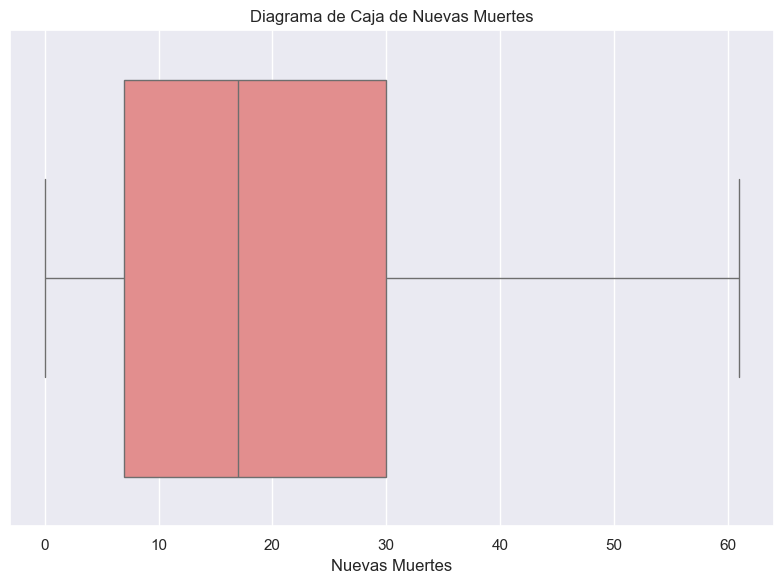

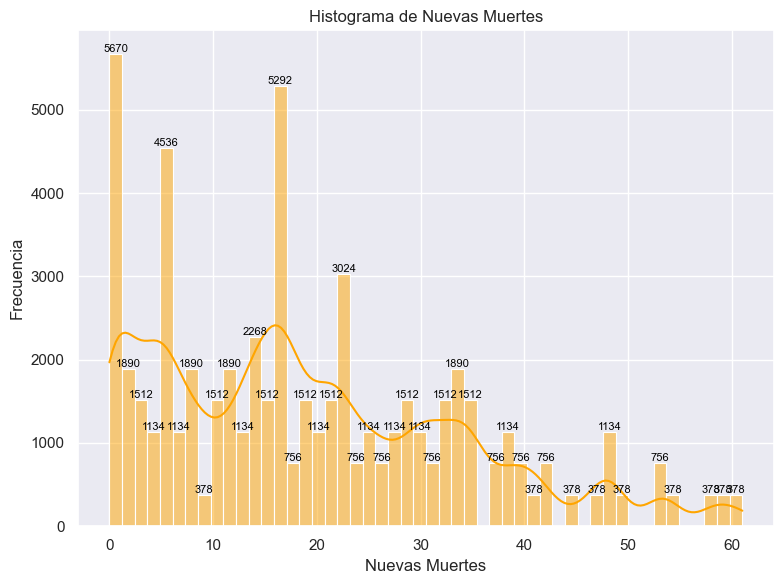

In [36]:
# Configurar estilo de visualización
sns.set(style="darkgrid", palette="muted")

# --- Diagrama de Caja: Nuevas Muertes ---
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['nuevas_muertes'], color='lightcoral')
plt.title("Diagrama de Caja de Nuevas Muertes")
plt.xlabel("Nuevas Muertes")
plt.tight_layout()
plt.show()

# --- Histograma Original: Nuevas Muertes ---
plt.figure(figsize=(8, 6))
histplot = sns.histplot(
    df['nuevas_muertes'],
    bins=50,
    kde=True,
    color='orange'
)
plt.title('Histograma de Nuevas Muertes')
plt.xlabel('Nuevas Muertes')
plt.ylabel('Frecuencia')

# Agregar valores encima de las barras
for p in histplot.patches:
    if p.get_height() > 0:
        plt.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=8, color='black'
        )

plt.tight_layout()
plt.show()

Variabilidad: A pesar de la concentración en la parte inferior, la presencia de valores atípicos indica que hubo algunos períodos con un número significativamente mayor de muertes. También se observa que la cantidad de muertes mientras más crece la frecuencia disminuye. Lo que sugiere que la cantidad de muertes no es constante.
Distribución: La distribución no parece ser completamente simétrica, ya que la cola superior (hacia los valores más altos) parece ser más larga que la cola inferior. Esto sugiere que podría haber algunos factores ocasionales que provoquen un aumento significativo en las muertes.

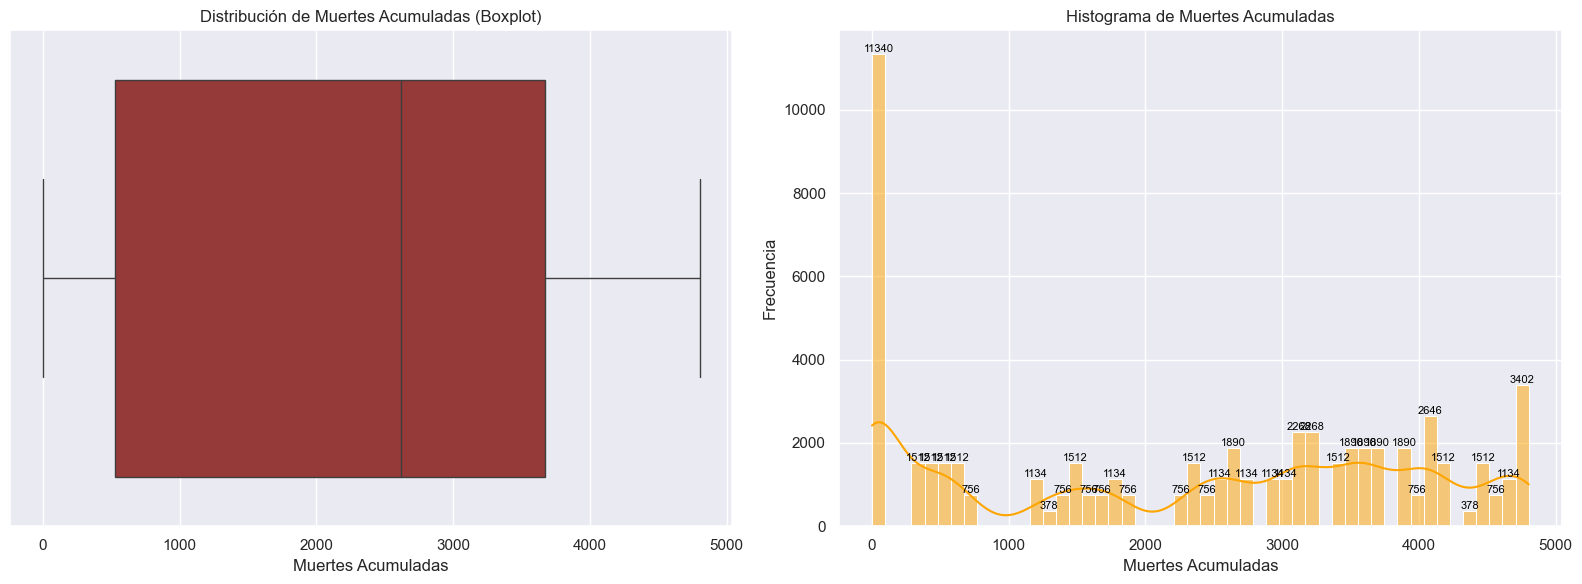

In [37]:
# Boxplot de Muertes Acumuladas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(
    x=df['muertes_acumuladas'],
    ax=axes[0],
    color='brown'
)
axes[0].set_title('Distribución de Muertes Acumuladas (Boxplot)')
axes[0].set_xlabel('Muertes Acumuladas')

# Histograma de Muertes Acumuladas
histplot = sns.histplot(
    df['muertes_acumuladas'],
    bins=50,
    kde=True,
    ax=axes[1],
    color='orange'
)
axes[1].set_title('Histograma de Muertes Acumuladas')
axes[1].set_xlabel('Muertes Acumuladas')
axes[1].set_ylabel('Frecuencia')

# Agregar valores exactos sobre las barras del histograma
for p in histplot.patches:  # Iterar sobre cada barra
    if p.get_height() > 0:  # Solo mostrar si la barra tiene altura
        axes[1].annotate(
            f'{int(p.get_height())}',  # Valor de la barra como entero
            (p.get_x() + p.get_width() / 2, p.get_height()),  # Posición centrada
            ha='center',  # Alineación horizontal
            va='bottom',  # Alineación vertical
            fontsize=8,  # Tamaño de fuente
            color='black'  # Color del texto
        )

plt.tight_layout()
plt.show()

Desigualdad en la distribución de muertes: Tanto el boxplot como el histograma indican que la distribución de las muertes acumuladas no es uniforme. Algunos municipios han experimentado un número significativamente mayor de muertes en comparación con otros.
Influencia de factores externos: Los valores atípicos y los picos en el histograma sugieren que factores externos, como la densidad poblacional, el acceso a servicios de salud, la presencia de brotes epidémicos o eventos naturales, pueden estar influyendo en la distribución de las muertes.
Variabilidad en los municipios: La amplia variabilidad en las muertes acumuladas sugiere que los municipios de Guatemala presentan características muy diferentes en términos de vulnerabilidad y respuesta a la crisis.

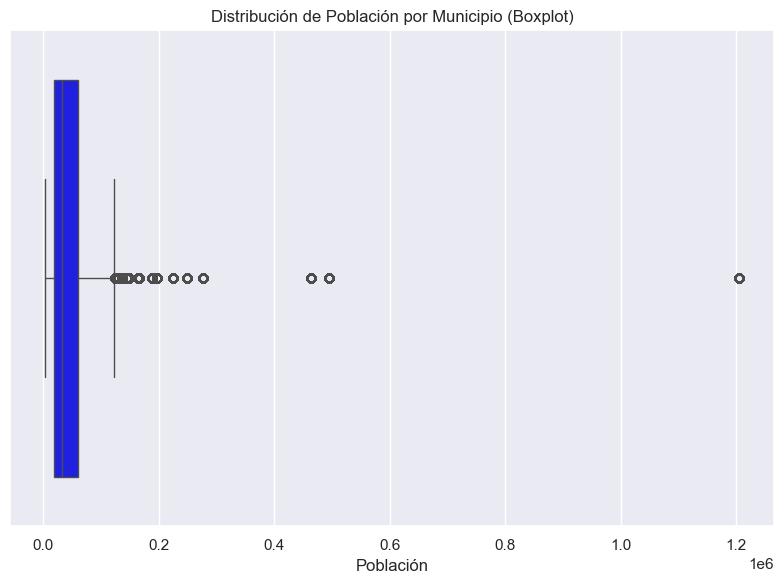

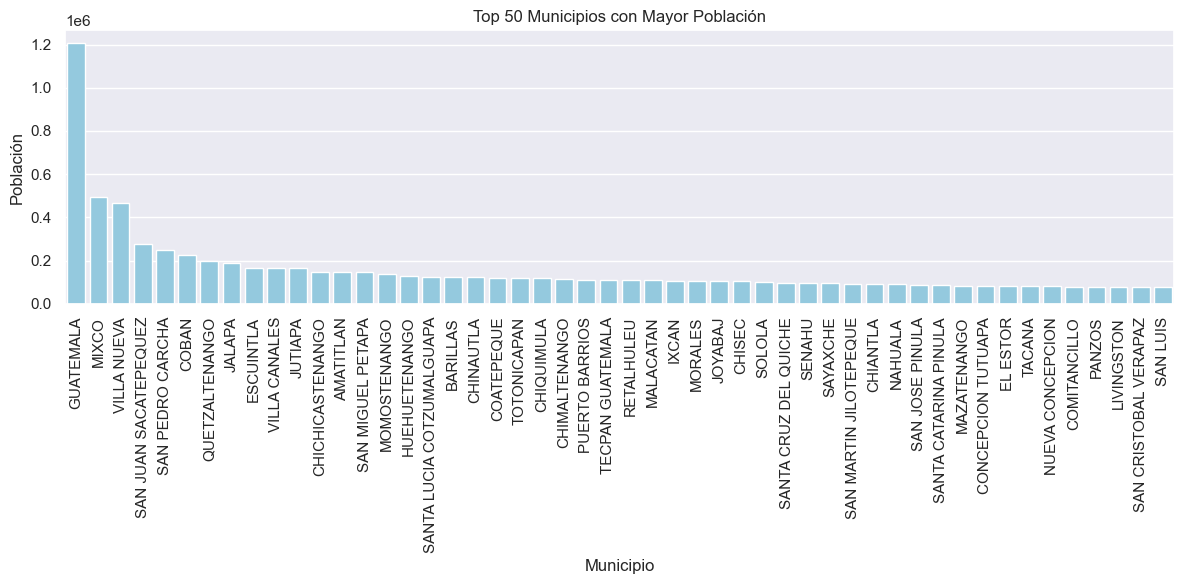

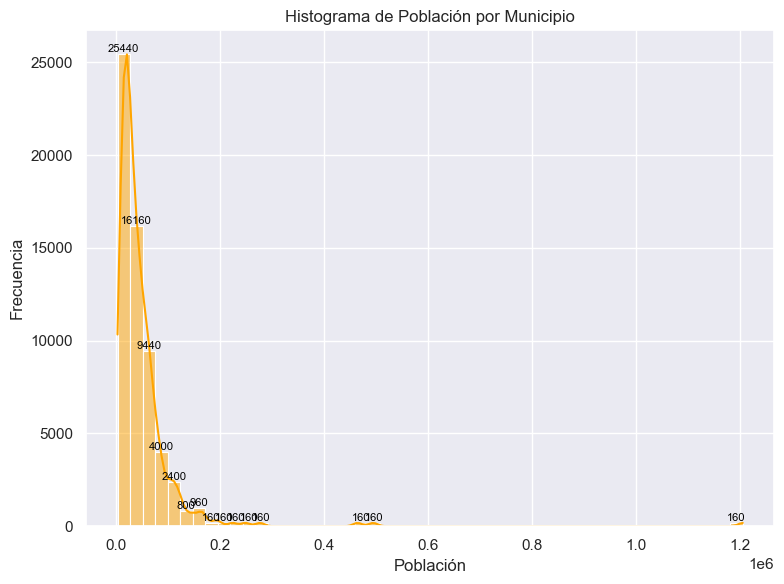

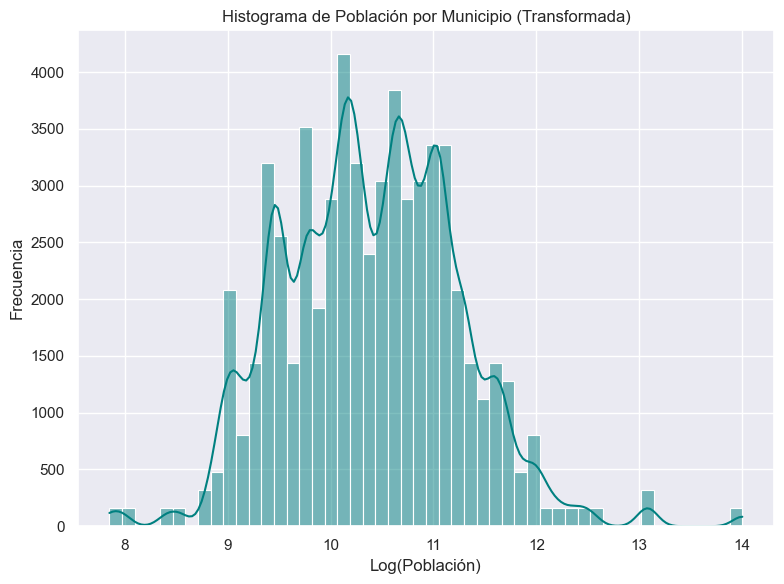

Sesgo original: 9.878596553618882
Nuevo sesgo después de la transformación: 0.2594165210263499


In [38]:
# Configurar estilo de visualización
sns.set(style="darkgrid", palette="muted")

# --- Diagrama de Caja: Población ---
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['poblacion'], color='blue')
plt.title("Distribución de Población por Municipio (Boxplot)")
plt.xlabel("Población")
plt.tight_layout()
plt.show()

# --- Gráfico de Barras: Top 50 Municipios con Mayor Población ---
# Filtrar los 50 municipios con mayor población
top_50_municipios_poblacion = (
    df[['municipio', 'poblacion']]
    .drop_duplicates('municipio')  # Filtrar municipios únicos
    .nlargest(50, 'poblacion')     # Seleccionar los 50 con mayor población
    .sort_values(by='poblacion', ascending=False)  # Ordenar por población
)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='municipio',
    y='poblacion',
    data=top_50_municipios_poblacion,
    color='skyblue'
)
plt.title("Top 50 Municipios con Mayor Población")
plt.xlabel("Municipio")
plt.ylabel("Población")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# --- Reducción del Sesgo mediante Transformación Logarítmica ---
# Calcular el sesgo original
original_skew = df['poblacion'].skew()

# Aplicar transformación logarítmica (log1p para evitar log(0))
df_poblacion_log = np.log1p(df['poblacion'])

# Calcular el sesgo después de la transformación
transformed_skew = df_poblacion_log.skew()

# --- Histograma Original: Población ---
plt.figure(figsize=(8, 6))
histplot = sns.histplot(
    df['poblacion'],
    bins=50,
    kde=True,
    color='orange'
)
plt.title("Histograma de Población por Municipio")
plt.xlabel("Población")
plt.ylabel("Frecuencia")

# Agregar valores exactos sobre las barras
for p in histplot.patches:
    if p.get_height() > 0:
        plt.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center', va='bottom', fontsize=8, color='black'
        )
plt.tight_layout()
plt.show()

# --- Histograma Transformado: Log(Población) ---
plt.figure(figsize=(8, 6))
histplot_log = sns.histplot(
    df_poblacion_log,
    bins=50,
    kde=True,
    color='teal'
)
plt.title("Histograma de Población por Municipio (Transformada)")
plt.xlabel("Log(Población)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# --- Mostrar sesgo antes y después de la transformación ---
print(f"Sesgo original: {original_skew}")
print(f"Nuevo sesgo después de la transformación: {transformed_skew}")

La mayoría de los municipios de Guatemala tienen una población relativamente pequeña. Esto se evidencia por el hecho de que la caja y la mediana se encuentran cerca del origen.
Distribución: La distribución de la población de los municipios de Guatemala es asimétrica, con una cola superior más larga que la cola inferior. Esto sugiere que algunos municipios tienen una población significativamente mayor que otros.
Pocos municipios muy poblados: Hacia la derecha del histograma, se observan unos pocos picos que representan municipios con una población significativamente mayor. Estos corresponden a las grandes ciudades y centros urbanos.
Pico central: La presencia de un pico central indica que existe un valor modal, es decir, un valor de población que se repite con mayor frecuencia.
Distribución más simétrica: Al aplicar la transformación logarítmica, la distribución de la población por municipio se ha vuelto más simétrica y con forma de campana. Esto indica que, en general, la distribución de la población sigue una distribución aproximadamente normal en una escala logarítmica.

In [39]:
# Código para detectar y mostrar outliers en cada columna de variables cuantitativas
for col in variables_cuantitativas:
    # Cálculo del primer y tercer cuartil
    Q1 = df[col].quantile(0.25)  # Primer cuartil (percentil 25)
    Q3 = df[col].quantile(0.75)  # Tercer cuartil (percentil 75)

    # Cálculo del rango intercuartílico (IQR)
    IQR = Q3 - Q1

    # Límites inferior y superior para los valores normales
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR

    # Identificación de outliers (valores fuera del rango aceptado)
    outliers = df[(df[col] < limite_inf) | (df[col] > limite_sup)]

    # Visualización de los resultados
    print(f"\nOutliers en {col}:")
    print(outliers)


Outliers en poblacion:
        departamento                  municipio  poblacion  \
0          GUATEMALA                  GUATEMALA    1205668   
1          GUATEMALA                  GUATEMALA    1205668   
2          GUATEMALA                  GUATEMALA    1205668   
3          GUATEMALA                  GUATEMALA    1205668   
4          GUATEMALA                  GUATEMALA    1205668   
...              ...                        ...        ...   
58235  HUEHUETENANGO  SANTA LUCIA COTZUMALGUAPA     123979   
58236  HUEHUETENANGO  SANTA LUCIA COTZUMALGUAPA     123979   
58237  HUEHUETENANGO  SANTA LUCIA COTZUMALGUAPA     123979   
58238  HUEHUETENANGO  SANTA LUCIA COTZUMALGUAPA     123979   
58239  HUEHUETENANGO  SANTA LUCIA COTZUMALGUAPA     123979   

                     fecha  nuevas_muertes  muertes_acumuladas  \
0      2020-03-15 00:00:00             0.0                   0   
1      2020-03-21 00:00:00             0.0                   1   
2      2020-04-15 00:00:00       

Repetición de datos: Lo más probable es que estos registros sean duplicados o errores en la base de datos. Es altamente improbable que un mismo municipio tenga una población tan grande repetida varias veces.

Ausencia de Outliers en Muertes y Nuevas Muertes
El hecho de que no se hayan identificado outliers en las variables relacionadas con muertes sugiere que:

Consistencia en los datos: Los datos de muertes han sido recopilados y procesados de manera más consistente, sin errores evidentes de digitación o duplicación.
Rango de valores razonable: Los valores de muertes y nuevas muertes se encuentran dentro de un rango esperado, sin valores extremadamente altos o bajos que llamen la atención.



## DATOS CUALITATIVOS

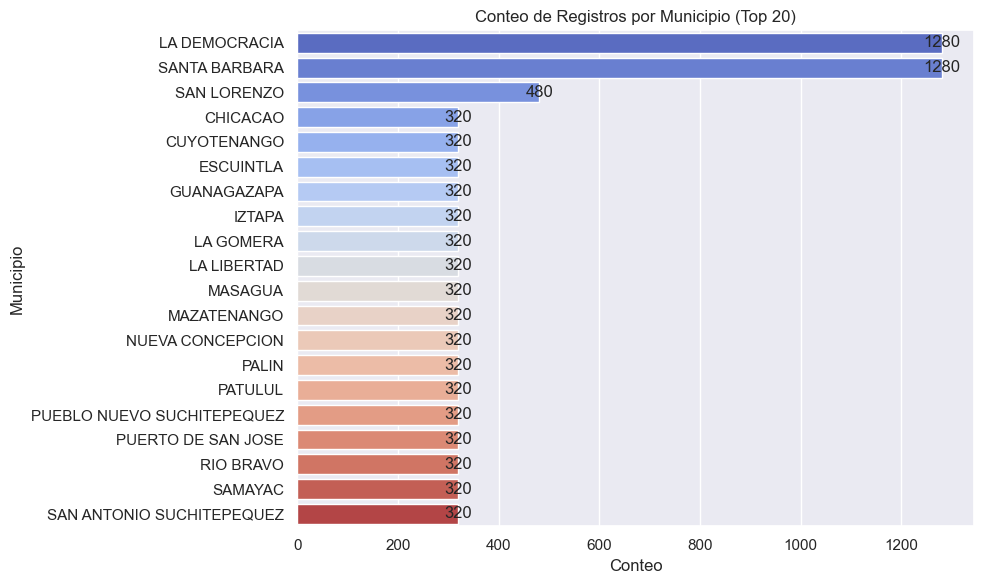

In [40]:
# Conteo de registros por Municipio
conteo_municipios = df.groupby('municipio').size().reset_index(name='conteo')

# Gráfico: Top 20 Municipios
plt.figure(figsize=(10, 6))
barplot_municipios = sns.barplot(
    x='conteo',
    y='municipio',
    data=conteo_municipios.nlargest(20, 'conteo'),
    palette='coolwarm',
    hue='municipio',
    legend=False  # Desactivar leyenda
)
plt.title('Conteo de Registros por Municipio (Top 20)')
plt.xlabel('Conteo')
plt.ylabel('Municipio')
plt.tight_layout()

# Agregar los valores sobre las barras
for bar in barplot_municipios.patches:
    plt.text(
        bar.get_width() + 0.5,  # Posición en X
        bar.get_y() + bar.get_height() / 2,  # Posición en Y
        int(bar.get_width()),  # Texto a mostrar
        ha='center', va='center'  # Centrado horizontal y vertical
    )

plt.show()

Menor cantidad de registros: los municipios que presentan el menor número de registros entre los 20 municipios mostrados. Esto puede deberse a varias razones, como menor población, menor actividad, o simplemente menos disponibilidad de datos.

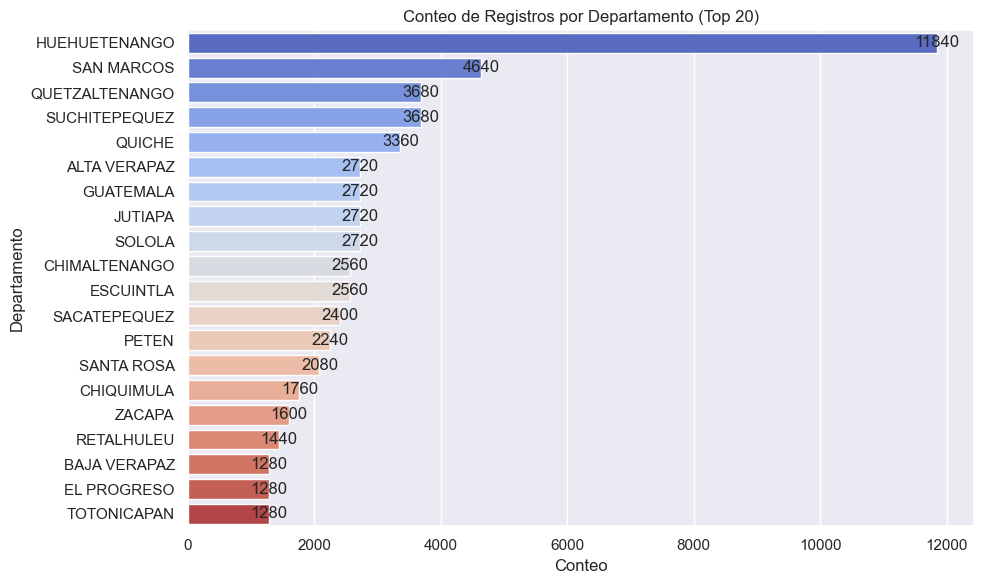

In [41]:
# Conteo de registros por Departamento
conteo_departamentos = df.groupby('departamento').size().reset_index(name='conteo')

# Gráfico: Top 20 Departamentos
plt.figure(figsize=(10, 6))
barplot_departamentos = sns.barplot(
    x='conteo',
    y='departamento',
    data=conteo_departamentos.nlargest(20, 'conteo'),
    palette='coolwarm',
    hue='departamento',
    legend=False  # Desactivar leyenda
)
plt.title('Conteo de Registros por Departamento (Top 20)')
plt.xlabel('Conteo')
plt.ylabel('Departamento')
plt.tight_layout()

# Agregar los valores sobre las barras
for bar in barplot_departamentos.patches:
    plt.text(
        bar.get_width() + 0.5,  # Posición en X
        bar.get_y() + bar.get_height() / 2,  # Posición en Y
        int(bar.get_width()),  # Texto a mostrar
        ha='center', va='center'  # Centrado horizontal y vertical
    )

plt.show()

Desigualdad en la cantidad de registros: Es evidente una gran disparidad en la cantidad de registros entre los diferentes departamentos. Huehuetenango y San Marcos concentran la mayor parte de los datos, mientras que otros departamentos como El Progreso o Totonicapán tienen una cantidad significativamente menor.
Diferencias en la población: Los departamentos con mayor población podrían tener, naturalmente, una mayor cantidad de registros.
Acceso a datos: Puede haber diferencias en la disponibilidad de datos a nivel departamental debido a factores como la infraestructura, la cooperación de las autoridades locales o la existencia de estudios específicos en ciertas regiones.

# EDA MULTIVARIABLE

## CUANTITATIVOS

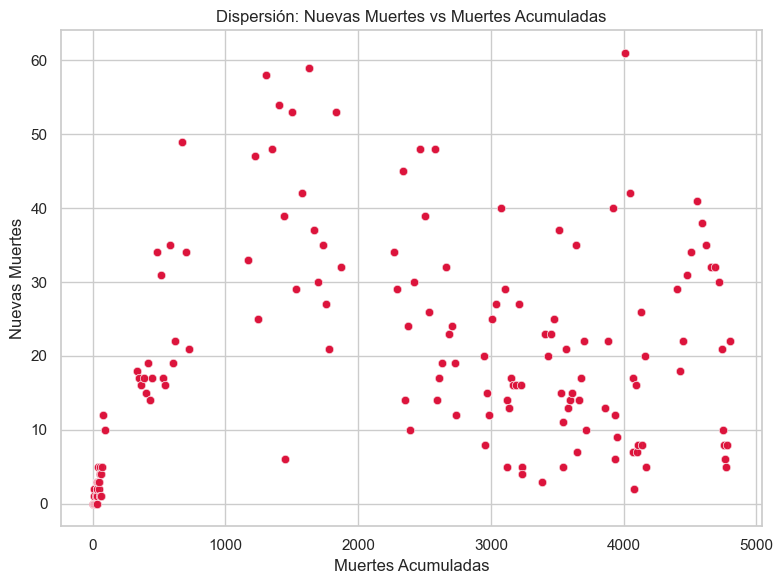

In [42]:
# Configurar estilo de visualización
sns.set(style="whitegrid", palette="muted")

# --- Gráfico 1: Nuevas Muertes vs. Muertes Acumuladas ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df['muertes_acumuladas'],
    y=df['nuevas_muertes'],
    color='crimson',
    alpha=0.7
)
plt.title("Dispersión: Nuevas Muertes vs Muertes Acumuladas")
plt.xlabel("Muertes Acumuladas")
plt.ylabel("Nuevas Muertes")
plt.tight_layout()
plt.show()


El gráfico de dispersión presentado relaciona dos variables: nuevas muertes y muertes acumuladas. Cada punto en el gráfico representa un registro donde se indica cuántas nuevas muertes se produjeron en un determinado período y el total acumulado de muertes hasta ese momento.
No existe una relación lineal clara: Los puntos no se distribuyen a lo largo de una línea recta, lo que indica que no hay una relación lineal directa entre las nuevas muertes y las muertes acumuladas. Es decir, un aumento en las muertes acumuladas no necesariamente implica un aumento proporcional en las nuevas muertes.
Tendencia general: A pesar de la dispersión, se observa una tendencia general: en los primeros tramos del eje X (muertes acumuladas bajas), hay una mayor concentración de puntos con valores bajos de nuevas muertes. A medida que aumenta el número de muertes acumuladas, se observa una mayor variabilidad en el número de nuevas muertes.

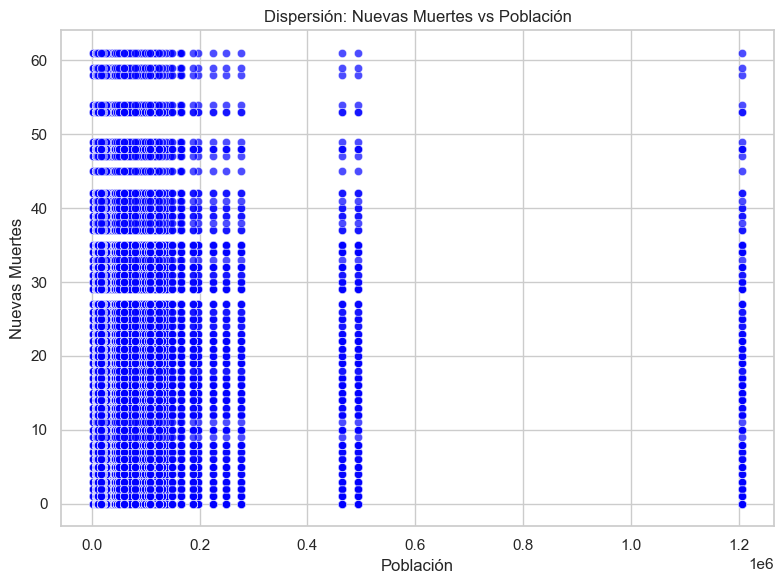

In [43]:
# --- Gráfico 2: Nuevas Muertes vs. Población ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df['poblacion'],
    y=df['nuevas_muertes'],
    color='blue',
    alpha=0.7
)
plt.title("Dispersión: Nuevas Muertes vs Población")
plt.xlabel("Población")
plt.ylabel("Nuevas Muertes")
plt.tight_layout()
plt.show()

No parece existir una clara relación lineal entre la población y las nuevas muertes; es decir, un aumento en la población no necesariamente implica un incremento proporcional en las muertes.

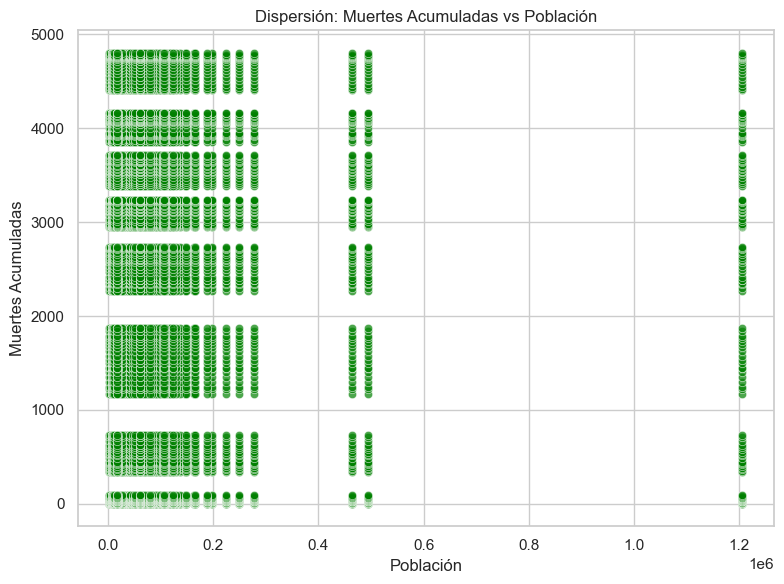

In [44]:
# --- Gráfico 3: Muertes Acumuladas vs. Población ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df['poblacion'],
    y=df['muertes_acumuladas'],
    color='green',
    alpha=0.7
)
plt.title("Dispersión: Muertes Acumuladas vs Población")
plt.xlabel("Población")
plt.ylabel("Muertes Acumuladas")
plt.tight_layout()
plt.show()

A diferencia del gráfico de nuevas muertes, aquí hay valores acumulados, lo que hace evidente que municipios con poblaciones mayores tienden a tener un número más alto de muertes acumuladas.
Dispersión vertical: Se observa una gran dispersión de los puntos en el eje vertical (muertes acumuladas), lo que sugiere que para un mismo tamaño de población, puede haber una gran variabilidad en el número total de muertes.

## CUALITATIVOS

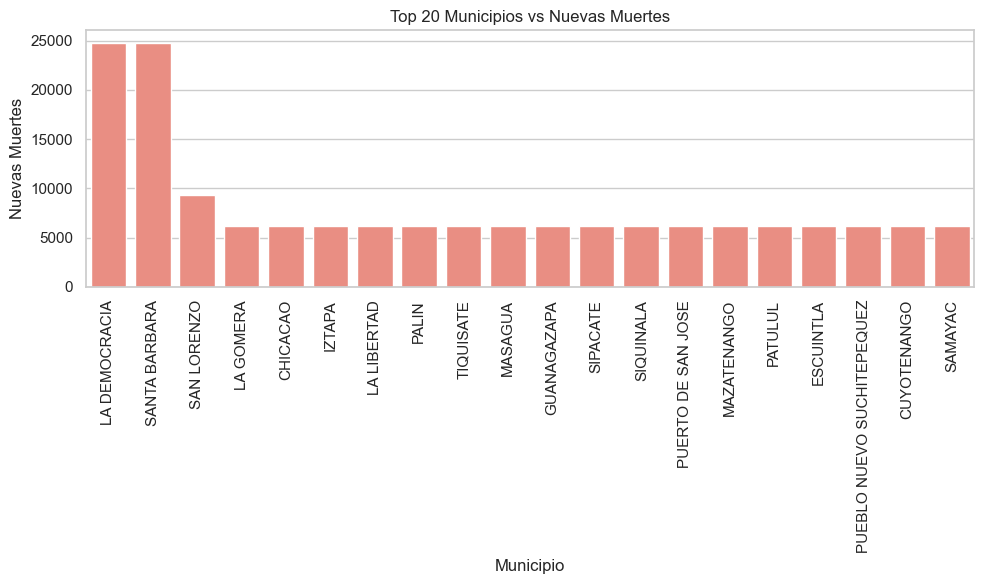

In [45]:
# Configurar estilo de visualización
sns.set(style="whitegrid", palette="muted")

# --- 1. Municipios vs Nuevas Muertes ---
plt.figure(figsize=(10, 6))
top_municipios_nuevas_muertes = df.groupby('municipio')['nuevas_muertes'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_municipios_nuevas_muertes.index, y=top_municipios_nuevas_muertes.values, color='salmon')
plt.title('Top 20 Municipios vs Nuevas Muertes')
plt.xlabel('Municipio')
plt.ylabel('Nuevas Muertes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Concentración de muertes: La mayoría de las muertes se concentran en unos pocos municipios, lo que sugiere que ciertos lugares han sido más afectados por la causa de COVID-19.

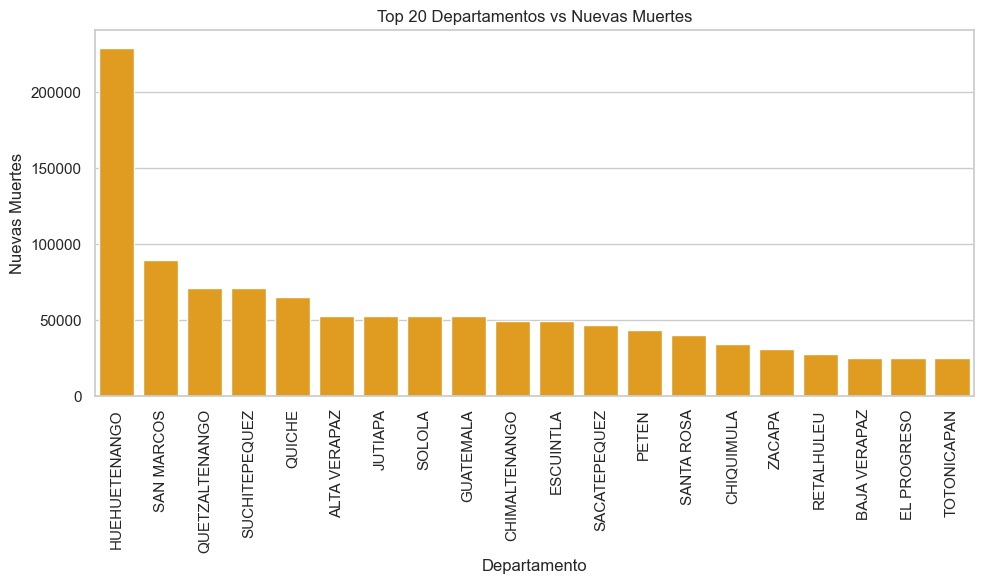

In [46]:
# --- 2. Departamentos vs Nuevas Muertes ---
plt.figure(figsize=(10, 6))
top_departamentos_nuevas_muertes = df.groupby('departamento')['nuevas_muertes'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_departamentos_nuevas_muertes.index, y=top_departamentos_nuevas_muertes.values, color='orange')
plt.title('Top 20 Departamentos vs Nuevas Muertes')
plt.xlabel('Departamento')
plt.ylabel('Nuevas Muertes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Acceso a servicios de salud: La disponibilidad y calidad de los servicios de salud pueden variar entre departamentos, lo que podría influir en las tasas de mortalidad.
Tamaño de la población: Los departamentos con mayor población podrían tener, naturalmente, un mayor número de muertes.

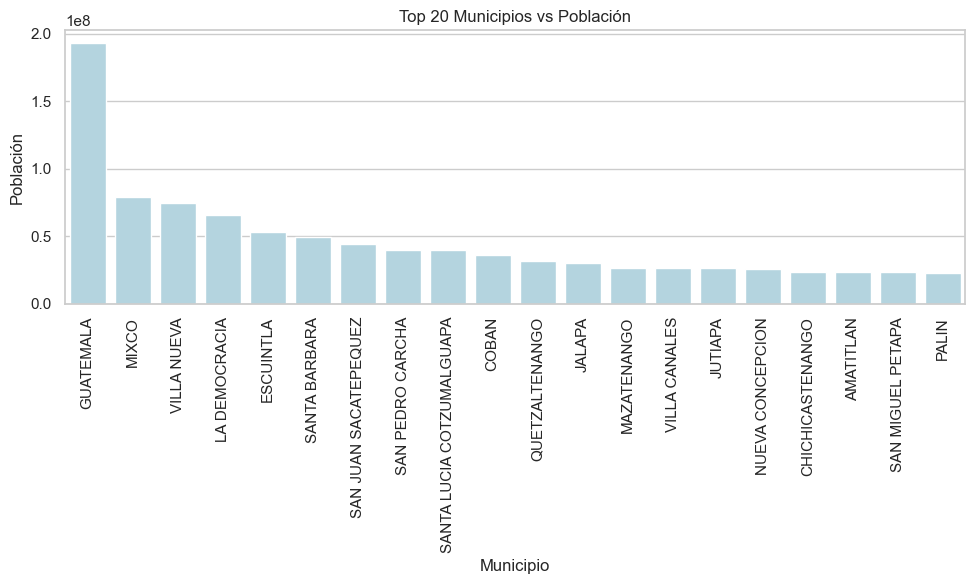

In [47]:
# --- 3. Municipio vs Población ---
plt.figure(figsize=(10, 6))
top_municipios_poblacion = df.groupby('municipio')['poblacion'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_municipios_poblacion.index, y=top_municipios_poblacion.values, color='lightblue')
plt.title('Top 20 Municipios vs Población')
plt.xlabel('Municipio')
plt.ylabel('Población')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


Concentración poblacional: La mayor parte de la población se concentra en unos pocos municipios, lo que sugiere que la distribución de la población en Guatemala es bastante desigual.

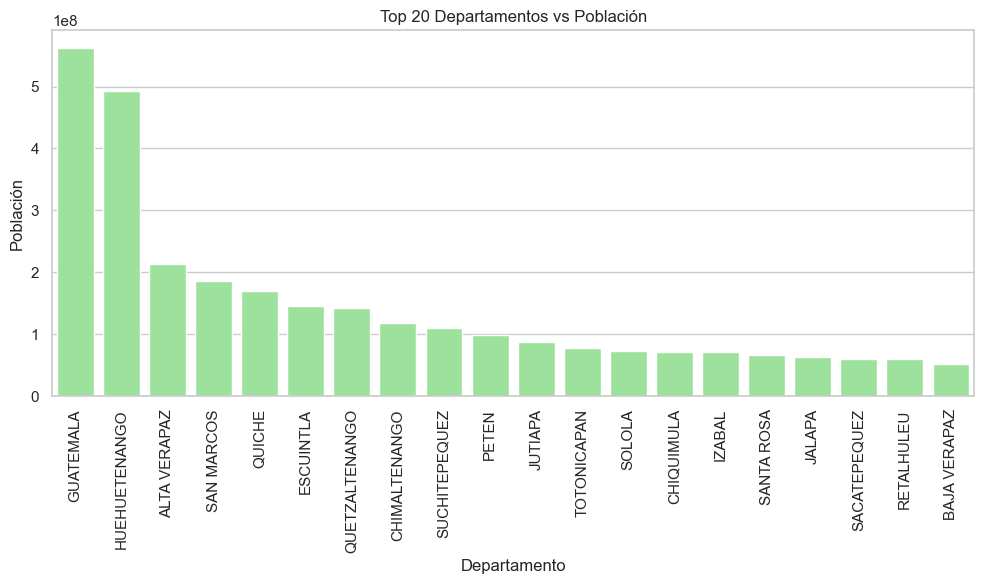

In [48]:
# --- 4. Departamento vs Población ---
plt.figure(figsize=(10, 6))
top_departamentos_poblacion = df.groupby('departamento')['poblacion'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_departamentos_poblacion.index, y=top_departamentos_poblacion.values, color='lightgreen')
plt.title('Top 20 Departamentos vs Población')
plt.xlabel('Departamento')
plt.ylabel('Población')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Desigualdad poblacional: Existe una gran disparidad en la población entre los diferentes departamentos. Los primeros lugares concentran una población significativamente mayor comparados con los últimos.


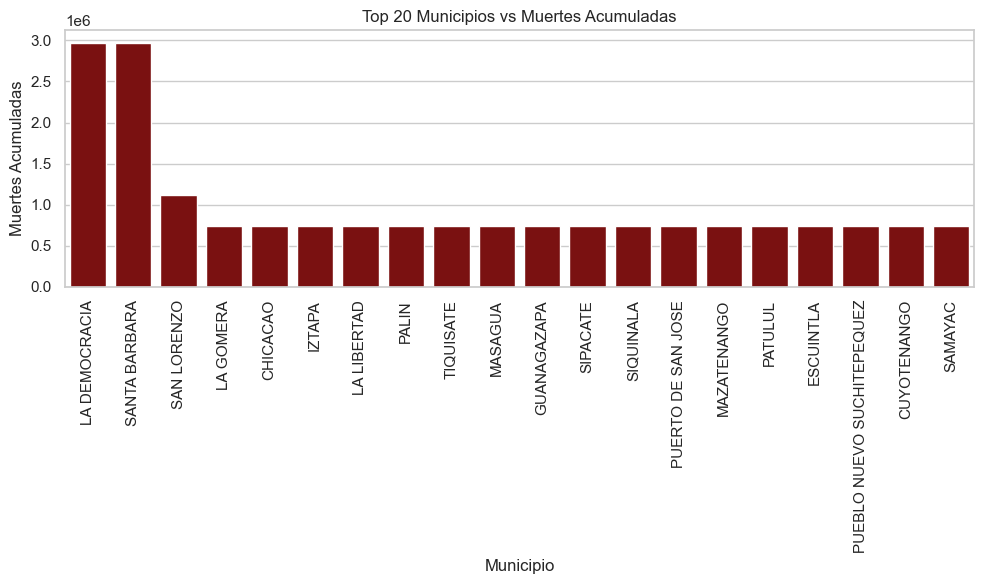

In [49]:
# --- 5. Municipios vs Muertes Acumuladas ---
plt.figure(figsize=(10, 6))
top_municipios_muertes_acumuladas = df.groupby('municipio')['muertes_acumuladas'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_municipios_muertes_acumuladas.index, y=top_municipios_muertes_acumuladas.values, color='darkred')
plt.title('Top 20 Municipios vs Muertes Acumuladas')
plt.xlabel('Municipio')
plt.ylabel('Muertes Acumuladas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Concentración de muertes: La mayoría de las muertes se concentran en unos pocos municipios, lo que sugiere que ciertas localidades han sido más afectadas por el COVID-19.

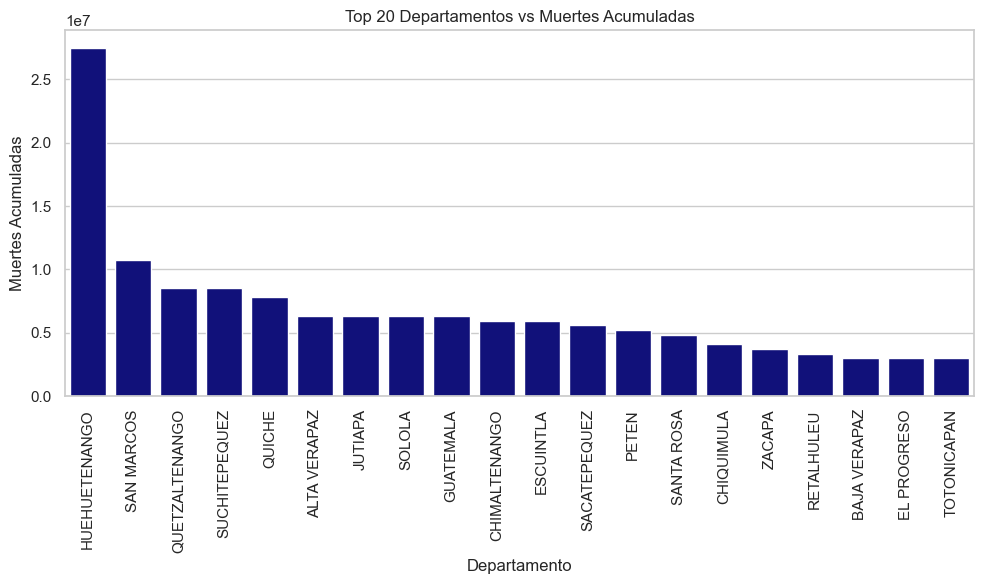

In [50]:
# --- 6. Departamentos vs Muertes Acumuladas ---
plt.figure(figsize=(10, 6))
top_departamentos_muertes_acumuladas = df.groupby('departamento')['muertes_acumuladas'].sum().sort_values(ascending=False).head(20)
sns.barplot(x=top_departamentos_muertes_acumuladas.index, y=top_departamentos_muertes_acumuladas.values, color='darkblue')
plt.title('Top 20 Departamentos vs Muertes Acumuladas')
plt.xlabel('Departamento')
plt.ylabel('Muertes Acumuladas')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Concentración de muertes: La mayoría de las muertes se concentran en unos pocos departamentos, lo que sugiere que ciertas regiones han sido más afectadas por el COVID-19.

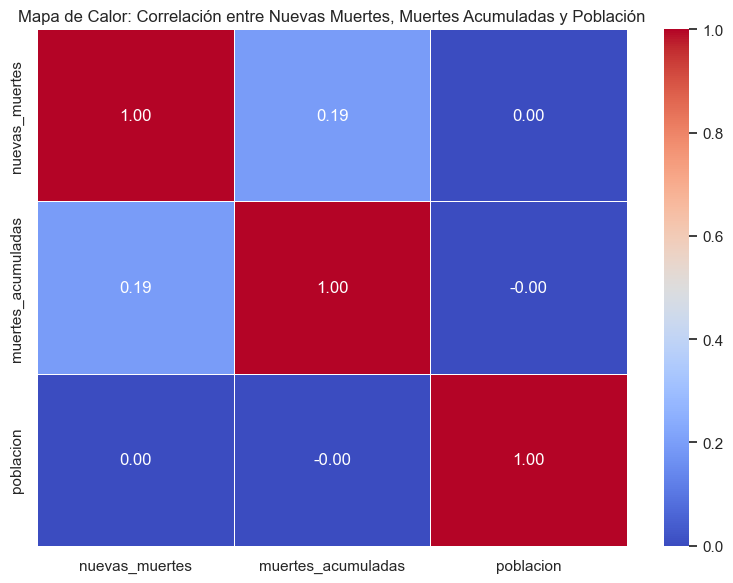

In [51]:
# --- 7. Mapa de Calor (Heatmap) de Correlación entre Variables Cuantitativas ---
# Se calcula la correlación entre las variables numéricas y luego se genera el mapa de calor
correlation_matrix = df[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor: Correlación entre Nuevas Muertes, Muertes Acumuladas y Población')
plt.tight_layout()
plt.show()

Nuevas muertes vs. Muertes acumuladas (valor de correlación: 0.19):

Existe una correlación positiva débil entre estas dos variables.
Esto significa que a medida que aumentan las nuevas muertes, tiende a aumentar ligeramente el número total de muertes acumuladas. Sin embargo, esta relación no es muy fuerte, lo que indica que otros factores también influyen en el número de muertes acumuladas.

Nuevas muertes vs. Población (valor de correlación: 0.00):

No existe una correlación significativa entre estas dos variables.
Esto sugiere que el número de nuevas muertes no está directamente relacionado con el tamaño de la población. Otros factores, como la densidad poblacional, las condiciones de salud o la presencia de brotes, podrían estar influyendo más en el número de nuevas muertes.

Muertes acumuladas vs. Población (valor de correlación: -0.00):

Tampoco existe una correlación significativa entre estas dos variables.
Esto indica que el número total de muertes acumuladas no está relacionado con el tamaño de la población. Al igual que en el caso anterior, otros factores podrían estar influyendo más en el número de muertes acumuladas.

## CORRELACIONES

In [52]:
# Asegurarse de que las columnas estén adecuadamente numeradas (para correlaciones)
df = df.copy()

# 1. Matriz de Correlación de Pearson (por defecto de pandas)
pearson_corr = df[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr(method='pearson')
print("Matriz de Correlación de Pearson:")
print(pearson_corr)

Matriz de Correlación de Pearson:
                    nuevas_muertes  muertes_acumuladas     poblacion
nuevas_muertes        1.000000e+00        1.947414e-01  5.915543e-16
muertes_acumuladas    1.947414e-01        1.000000e+00 -2.510672e-15
poblacion             5.915543e-16       -2.510672e-15  1.000000e+00


nuevas_muertes vs nuevas_muertes (1.000):
La diagonal principal de la matriz siempre tiene un valor de 1 porque cualquier variable está perfectamente correlacionada consigo misma.

nuevas_muertes vs muertes_acumuladas (0.1947):
Existe una correlación positiva débil entre las nuevas muertes y las muertes acumuladas. Esto indica que a medida que aumentan las nuevas muertes, también tienden a aumentar las muertes acumuladas, pero la relación no es fuerte.

nuevas_muertes vs poblacion (5.91e-16 ≈ 0):
La correlación es prácticamente nula, lo que significa que no existe una relación lineal entre la cantidad de nuevas muertes y la población. Esto puede ser un indicio de que otros factores, más allá del tamaño de la población, influyen en las nuevas muertes.

muertes_acumuladas vs poblacion (-2.51e-15 ≈ 0):
De manera similar, la correlación entre las muertes acumuladas y la población también es prácticamente nula. A pesar de que visualmente en el gráfico anterior parecía que poblaciones grandes tendían a tener más muertes acumuladas, la correlación numérica no muestra una relación lineal significativa.

muertes_acumuladas vs muertes_acumuladas (1.000):
Como se espera, la variable tiene una correlación perfecta consigo misma.

In [53]:
# 2. Matriz de Correlación de Spearman
spearman_corr = df[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr(method='spearman')
print("\nMatriz de Correlación de Spearman:")
print(spearman_corr)


Matriz de Correlación de Spearman:
                    nuevas_muertes  muertes_acumuladas  poblacion
nuevas_muertes            1.000000            0.266887        0.0
muertes_acumuladas        0.266887            1.000000        0.0
poblacion                 0.000000            0.000000        1.0


nuevas_muertes vs nuevas_muertes (1.000):
Es una correlación perfecta consigo misma, como es esperado.

nuevas_muertes vs muertes_acumuladas (0.2669):
Existe una correlación positiva débil entre nuevas muertes y muertes acumuladas.

Esto implica que a medida que aumentan las nuevas muertes, tiende a haber un incremento en las muertes acumuladas.
Aunque la relación no es fuerte, es un poco más notable que en Pearson (donde fue 0.19).
nuevas_muertes vs poblacion (0.0):
La correlación es nula, lo que significa que no hay relación monotónica entre la cantidad de nuevas muertes y la población.

Esto sugiere que, en términos de rangos, el tamaño de la población no influye en la cantidad de nuevas muertes.
muertes_acumuladas vs poblacion (0.0):
La correlación también es nula, lo que indica que no existe una relación monotónica entre la población y las muertes acumuladas.

Esto confirma lo observado en la matriz de Pearson: a pesar de lo visualizado en los gráficos, la relación estadística no es significativa.
poblacion vs poblacion (1.000):
Como es de esperarse, una variable tiene correlación perfecta consigo misma.

In [54]:
# 3. Matriz de Correlación de Kendall
kendall_corr = df[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']].corr(method='kendall')
print("\nMatriz de Correlación de Kendall:")
print(kendall_corr)


Matriz de Correlación de Kendall:
                    nuevas_muertes  muertes_acumuladas  poblacion
nuevas_muertes            1.000000            0.170723        0.0
muertes_acumuladas        0.170723            1.000000        0.0
poblacion                 0.000000            0.000000        1.0


nuevas_muertes vs nuevas_muertes (1.000):
Correlación perfecta consigo misma, como es natural.

nuevas_muertes vs muertes_acumuladas (0.1707):
Existe una correlación positiva débil entre nuevas muertes y muertes acumuladas.

Este valor es más bajo que en Spearman (0.2669) y en Pearson (0.19), lo cual indica que la relación es débil y no necesariamente lineal ni estrictamente monotónica.
Aun así, refleja la tendencia esperada: cuando aumentan las nuevas muertes, también tienden a incrementarse las muertes acumuladas.
nuevas_muertes vs poblacion (0.0):
La correlación es nula, lo que indica que no existe una relación significativa entre el número de nuevas muertes y la población en términos de rangos o tendencias.

muertes_acumuladas vs poblacion (0.0):
La correlación también es nula, indicando que no existe relación monotónica entre la población y las muertes acumuladas.

poblacion vs poblacion (1.000):
Como es de esperarse, la correlación de una variable consigo misma es 1.

In [55]:
# 4. Test Chi-cuadrado (para variables categóricas)
# Asegúrate de que las columnas 'municipio' y 'departamento' sean de tipo categórico o 'object'
# Primero, se genera una tabla de contingencia para cada par de variables categóricas
contingency_municipio_nuevas_muertes = pd.crosstab(df['municipio'], df['nuevas_muertes'])
chi2, p_value, dof, expected = chi2_contingency(contingency_municipio_nuevas_muertes)
print(f"\nTest Chi-Cuadrado entre Municipio y Nuevas Muertes:\nEstadística: {chi2}, p-value: {p_value}")

contingency_departamento_nuevas_muertes = pd.crosstab(df['departamento'], df['nuevas_muertes'])
chi2, p_value, dof, expected = chi2_contingency(contingency_departamento_nuevas_muertes)
print(f"\nTest Chi-Cuadrado entre Departamento y Nuevas Muertes:\nEstadística: {chi2}, p-value: {p_value}")


Test Chi-Cuadrado entre Municipio y Nuevas Muertes:
Estadística: 0.0, p-value: 1.0

Test Chi-Cuadrado entre Departamento y Nuevas Muertes:
Estadística: 0.0, p-value: 1.0



Estadística de Chi-Cuadrado = 0.0:
Una estadística de 0.0 significa que no existe ninguna diferencia entre las frecuencias observadas y esperadas. En otras palabras, la distribución de Nuevas Muertes es independiente de las variables Municipio y Departamento.

p-value = 1.0:
Un p-value de 1.0 indica que no hay evidencia estadística para rechazar la hipótesis nula.

La hipótesis nula en este contexto es que no existe asociación entre las variables (Municipio/Nuevas Muertes o Departamento/Nuevas Muertes).
Dado que el p-value es muy superior al umbral común de 0.05, no hay ninguna relación significativa entre estas variables.

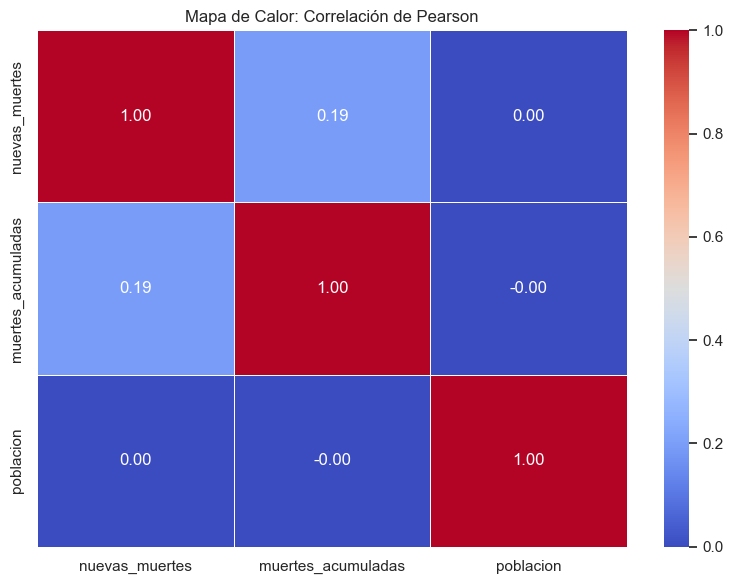

In [56]:
# 5. Gráfico de Correlación con Mapa de Calor (Pearson)
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor: Correlación de Pearson')
plt.tight_layout()
plt.show()

Nuevas muertes vs. Muertes acumuladas (valor de correlación: 0.19):

Existe una correlación positiva débil entre estas dos variables.
Esto significa que a medida que aumentan las nuevas muertes, tiende a aumentar ligeramente el número total de muertes acumuladas. Sin embargo, esta relación no es muy fuerte, lo que indica que otros factores también influyen en el número de muertes acumuladas.

Nuevas muertes vs. Población (valor de correlación: 0.00):

No existe una correlación significativa entre estas dos variables.
Esto sugiere que el número de nuevas muertes no está directamente relacionado con el tamaño de la población. Otros factores, como la densidad poblacional, las condiciones de salud o la presencia de brotes, podrían estar influyendo más en el número de nuevas muertes.

Muertes acumuladas vs. Población (valor de correlación: -0.00):

Tampoco existe una correlación significativa entre estas dos variables.
Esto indica que el número total de muertes acumuladas no está relacionado con el tamaño de la población. Al igual que en el caso anterior, otros factores podrían estar influyendo más en el número de muertes acumuladas.

In [57]:
# Añade una columna de constantes
X = df[['nuevas_muertes', 'muertes_acumuladas', 'poblacion']]
X_const = add_constant(X)

# Verificar y solucionar problemas de NaN o Inf en los datos
if X_const.isnull().values.any() or np.isinf(X_const.values).any():
    # Opciones para manejar valores faltantes o infinitos:
    # Eliminar filas con NaN o Inf
    X_const = X_const.replace([np.inf, -np.inf], np.nan).dropna()

# Crear DataFrame para almacenar el VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])
]

# Mostrar los resultados de VIF
print("\nAnálisis de Multicolinealidad (VIF):")
print(vif_data)


Análisis de Multicolinealidad (VIF):
             Variable       VIF
0               const  4.590985
1      nuevas_muertes  1.039419
2  muertes_acumuladas  1.039419
3           poblacion  1.000000


Variable	VIF	Interpretación
const	4.590985	El término constante tiene un VIF elevado. Es común en modelos con intercepciones y no suele ser problemático.
nuevas_muertes	1.039419	La multicolinealidad es prácticamente nula. La variable es independiente de las demás.
muertes_acumuladas	1.039419	Al igual que nuevas_muertes, no presenta multicolinealidad significativa.
poblacion	1.000000	No hay multicolinealidad en absoluto para esta variable.

## Hallazgos Clave y Anomalías

1. **Análisis de Datos COVID-19**:
   - Se han identificado **60480 registros** de datos relacionados con muertes y casos confirmados en diferentes municipios.
   - La variable de **población** presenta un sesgo alto (9.88), lo que sugiere la necesidad de aplicar transformaciones logarítmicas para una mejor interpretación.

2. **Distribución de Muertes**:
   - La distribución de muertes acumuladas muestra una gran variabilidad entre municipios, indicando desigualdades en la respuesta a la crisis sanitaria.

3. **Outliers**:
   - Se identificaron outliers en la población, sugiriendo posibles errores en los datos o duplicados, lo que requiere una revisión más exhaustiva.

4. **Transformación Logarítmica**:
   - La transformación logarítmica aplicada a la población ha reducido el sesgo, mejorando la simetría de los datos.

5. **Visualizaciones**:
   - Los diagramas de caja y histogramas revelan patrones significativos en las nuevas muertes y muertes acumuladas, destacando periodos con picos inusuales.

## Áreas que Requieren Mayor Investigación

- **Impacto de Factores Externos**: Investigar cómo factores como la densidad poblacional y el acceso a servicios de salud influyen en las tasas de mortalidad.
- **Efectos de Políticas Sanitarias**: Evaluar la efectividad de las políticas implementadas en diferentes municipios para mitigar el impacto del COVID-19.
- **Análisis Temporal**: Realizar un análisis más profundo sobre cómo las tasas de infección y mortalidad han cambiado a lo largo del tiempo.
- **Comparación Regional**: Comparar los datos con otras regiones para entender mejor las dinámicas locales frente a la pandemia.
- **Calidad de Datos**: Mejorar los métodos de recolección y validación de datos para asegurar su consistencia y precisión.

## Conclusiones Relevantes para la Toma de Decisiones

1. **Necesidad de Intervenciones Localizadas**:
   - La variabilidad en las tasas de mortalidad entre diferentes municipios indica que no todos están enfrentando la crisis sanitaria de la misma manera. Esto sugiere que las intervenciones deben ser adaptadas a las características específicas de cada localidad, considerando factores como la densidad poblacional, el acceso a servicios de salud y las condiciones socioeconómicas.

2. **Importancia del Monitoreo Continuo**:
   - Establecer un sistema de monitoreo continuo permitirá a las autoridades sanitarias detectar rápidamente cambios en las tendencias de casos y muertes. Esto facilitará la implementación de medidas preventivas o correctivas en tiempo real, mejorando así la efectividad de la respuesta ante futuras olas de contagio.

3. **Priorizar Recursos en Áreas Críticas**:
   - Los datos muestran que ciertos municipios presentan tasas significativamente más altas de muertes. Por lo tanto, es crucial asignar recursos adicionales, como equipos médicos y personal sanitario, a estas áreas para mitigar el impacto del COVID-19 y mejorar la atención a los pacientes.

4. **Formación y Capacitación**:
   - La consistencia en los datos y su correcta interpretación son fundamentales para una gestión efectiva. Por ello, es esencial implementar programas de formación para el personal médico y administrativo que maneja estos datos, asegurando que comprendan cómo registrar y analizar información relevante para la toma de decisiones.

5. **Investigación Adicional sobre Outliers**:
   - La identificación de outliers en los datos sugiere que pueden existir errores o anomalías en el registro. Es importante realizar investigaciones adicionales para entender el origen de estos valores atípicos, lo que podría ayudar a mejorar los procesos de recolección y validación de datos en el futuro.
